In [205]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize
from scipy.spatial.distance import cdist
import statistics
from IPython.display import display, Math, Latex
%matplotlib inline



# Non-intrusive sequential SVGD

Algorithm: Given particles $(x_j)_{j=1}^{N-1}$, find the new particle $z$ by optimizing the particle position recurrently applying the SVGD formula $x \gets x + \varepsilon f(z)$, where
$f(z) = \nabla\log\pi(z) + \sum_{j=1}^{N-1} \left[ \nabla \log\pi(x_j)k(z, x_j) + \nabla_{x_j}k(z,x_j) \right]$ .
If we assume convergence of the method, the particle $z$ will reach a converging value $z^*$, which is equivalent to
$$z^* = \text{argmax}_z F(z) ,$$
where $F(z) := \int_\alpha f(z')\cdot dz'$, where $\alpha$ is some path with $z$ as endpoint (Gradient theorem). Note that the result is independent on the choice of the path $\alpha$, but a nice choice of $\alpha$ will facilitate the explicit calculation of $F(z)$. I choose $\alpha:(-\infty,1)\to \mathbb{R}^d: t\mapsto t z$. I use kernel
$k(x,z) = e^{-\gamma (x-z)^\top (x-z)}$. Hence, we can calculate $F(z)$ explicitely, which results into

$$ F(z) = \log\pi(z) + \sum_{j=1}^{N-1} \left[ \nabla \log\pi(x_j)\int_{-\infty}^1 k(tz, x_j)\,dt + \int_{-\infty}^1\nabla_{x_j}k(tz,x_j)\,dt \right]^\top z $$
$$~\quad = \log\pi(z) + \sum_{j=1}^{N-1} \left[ \nabla \log\pi(x_j)^\top z \sqrt{\frac{\pi}{\gamma z^\top z}}\,\Phi\left(1, \mu = \frac{x_j^\top z}{z^\top z}, \sigma = \frac{1}{\sqrt{2\gamma z^\top z}}\right)\, e^{-\gamma \left(x_j^\top x_j - \frac{(x_j^\top z)^2}{z^\top z}\right)} - k(z,x_j)\right], $$
where $\Phi$ is the normal CDF.
To optimize the particle, the function $F$ can then be given to an off-the-shelf optimizer (optionally together with its gradient $f$), with obvious advantages.
With the function $F$, we can now also perform proper line-search methods for faster optimizations.

# Questions:
- What is the relation between a sequential SVN and a second-order optimization on $F(z)$?
- Can we prove that the sequential method converges properly (which I observe numerically for both SVN and SVGD)? Check on "Stein Points" from C. Oates.

In [346]:
class SeqSVGD:
    def __init__(self, model):
        self.model = model
        self.DoF   = self.model.DoF
        self.MAP   = self.model.getMAP().reshape(self.DoF, 1)
        
        self.particles  = self.MAP
        self.gmlpts = self.model.getGradientMinusLogPosterior(self.particles).reshape(self.DoF, 1)        
        self.mlpts  = self.model.getMinusLogPosterior(self.particles)
        self.nParticles = 1
        
    def apply(self):
        if self.nParticles > 1:
            dist2 = cdist(self.particles.T, self.particles.T, 'sqeuclidean')
            med2  = statistics.median( dist2[dist2 != 0] )
            self.gamma = np.log( self.nParticles ) / med2
        else:
            self.gamma = 1
            
        particle = self.generateParticle()
        res = optimize.minimize(self.func2minimize, particle, method='L-BFGS-B')

        self.particles = np.hstack( (self.particles, res.x[:,np.newaxis]) )
        self.gmlpts    = np.hstack( (self.gmlpts, self.model.getGradientMinusLogPosterior(res.x).reshape(self.DoF, 1)) )
        self.mlpts     = np.hstack( (self.mlpts, self.mlpt) )
        
        self.nParticles += 1
            
    def generateParticle(self):
        return self.MAP + np.random.normal( scale = 0.1, size = (self.DoF, 1) )
    
    def func2minimize(self, z):
        self.mlpt = self.model.getMinusLogPosterior(z)

        ztz = np.dot(z, z)
        xtz = np.sum( self.particles * z[:,np.newaxis], 0 )
        xtx = np.sum( self.particles * self.particles, 0 )
        xzdiff = self.particles - z[:,np.newaxis]
        mus = xtz / ztz
        gamztz = self.gamma * ztz
        std = 1 / np.sqrt( 2 * gamztz )
        cdfnorm = stats.norm.cdf(1, mus, std)
        normconst = np.sqrt( np.pi / gamztz )
        extraexp = np.exp( - self.gamma * ( xtx - xtz * mus ) )
        kern = np.exp( - self.gamma * np.sum(xzdiff ** 2, 0) )
        
        return self.mlpt + np.sum( np.sum(self.gmlpts * z[:,np.newaxis], 0) * normconst * cdfnorm * extraexp + kern )
        

In [337]:
class GAUSSIAN():
    def __init__(self):
        self.DoF = 2
        self.nData = 1
        self.mu0 = np.zeros((self.DoF, 1))
        self.std0 = np.ones((self.DoF,1))
        self.var0 = self.std0 ** 2
        self.stdn = 0.3
        self.varn = self.stdn ** 2
        
        np.random.seed(40)
        self.A    = np.random.normal( size = (self.DoF, 1) )
        self.thetaTrue = np.random.normal(size = self.DoF)
        self.data = self.simulateData()
        
    def getForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.sum(self.A * thetas, 0)
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getJacobianForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.matlib.repmat(self.A, 1, nSamples)
        return tmp if nSamples > 1 else tmp.squeeze()
        
    def simulateData(self):
        noise = np.random.normal( scale = self.stdn, size = (1, self.nData) )
        return self.getForwardModel(self.thetaTrue) + np.random.normal( scale = self.stdn, size = (1, self.nData) )
        
    def getMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        shift = thetas - self.mu0
        tmp = 0.5 * np.sum( shift ** 2 / self.var0, 0 )
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)
        shift = F - self.data
        tmp = 0.5 * np.sum( shift ** 2, 0 ) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogPosterior(self, thetas, *arg):
        return self.getMinusLogPrior(thetas) + self.getMinusLogLikelihood(thetas, *arg)
    
    def getGradientMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = (thetas - self.mu0) / self.var0
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)   
        J = arg[1] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J * np.sum(F - self.data, 0) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogPosterior(self, thetas, *arg):
        return self.getGradientMinusLogPrior(thetas) + self.getGradientMinusLogLikelihood(thetas, *arg)
    
    def getGNHessianMinusLogPosterior(self, thetas, *arg):        
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        J = arg[0] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J.reshape(self.DoF, 1, nSamples) * J.reshape(1, self.DoF, nSamples) / self.varn \
              + (np.eye(self.DoF) / self.var0)[:,:,np.newaxis]
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMAP(self, *arg):
        x0 = arg[0] if len(arg) > 0 else np.random.normal(size = self.DoF)
        res = optimize.minimize(self.getMinusLogPosterior, x0, method='L-BFGS-B')
        return res.x

In [338]:
model = GAUSSIAN()

In [339]:
ssvgd = SeqSVGD(model)

In [344]:
for i in range(100):
    ssvgd.apply()

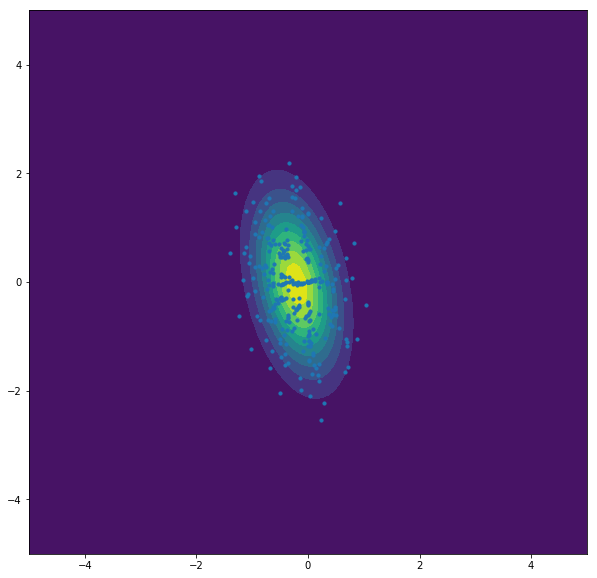

In [345]:
ngrid = 100
x = np.linspace(-5, 5, ngrid)
y = np.linspace(-5, 5, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) ) \
                .reshape(ngrid, ngrid)
plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(ssvgd.particles[0], ssvgd.particles[1], s = 10)

In [257]:
class DOUBLEBANANA():
    def __init__(self):
        self.DoF = 2
        self.nData = 1
        self.mu0 = np.zeros((self.DoF, 1))
        self.std0 = np.ones((self.DoF,1))
        self.var0 = self.std0 ** 2
        self.stdn = 0.3
        self.varn = self.stdn ** 2
        
        np.random.seed(40)
        self.thetaTrue = np.random.normal(size = self.DoF)
        self.data = self.simulateData()
        
    def getForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.log( ( 1 - thetas[0] ) ** 2 + 100 * ( thetas[1] - thetas[0] ** 2 ) ** 2 )
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getJacobianForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.vstack( ( \
          ( 2 * ( thetas[0,:] - 1 - 200 * thetas[0,:] * (thetas[1,:] - thetas[0,:] ** 2) ) ) \
           / ( 1 + thetas[0,:] ** 2 - 2 * thetas[0,:] + 100 * (thetas[1,:] - thetas[0,:] ** 2) ** 2 ), \
          ( 200 * (thetas[1,:] - thetas[0,:] ** 2) ) \
           / ( 1 + thetas[0,:] ** 2 - 2 * thetas[0,:] + 100 * (thetas[1,:] - thetas[0,:] ** 2) ** 2 ) \
                         ) )
        return tmp if nSamples > 1 else tmp.squeeze()
        
    def simulateData(self):
        noise = np.random.normal( scale = self.stdn, size = (1, self.nData) )
        return self.getForwardModel(self.thetaTrue) + np.random.normal( scale = self.stdn, size = (1, self.nData) )
        
    def getMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        shift = thetas - self.mu0
        tmp = 0.5 * np.sum( shift ** 2 / self.var0, 0 )
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)
        shift = F - self.data
        tmp = 0.5 * np.sum( shift ** 2, 0 ) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogPosterior(self, thetas, *arg):
        return self.getMinusLogPrior(thetas) + self.getMinusLogLikelihood(thetas, *arg)
    
    def getGradientMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = (thetas - self.mu0) / self.var0
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)   
        J = arg[1] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J * np.sum(F - self.data, 0) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogPosterior(self, thetas, *arg):
        return self.getGradientMinusLogPrior(thetas) + self.getGradientMinusLogLikelihood(thetas, *arg)
    
    def getGNHessianMinusLogPosterior(self, thetas, *arg):        
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        J = arg[0] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J.reshape(self.DoF, 1, nSamples) * J.reshape(1, self.DoF, nSamples) / self.varn \
              + (np.eye(self.DoF) / self.var0)[:,:,np.newaxis]
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMAP(self, *arg):
        x0 = arg[0] if len(arg) > 0 else np.random.normal(size = self.DoF)
        res = optimize.minimize(self.getMinusLogPosterior, x0, method='L-BFGS-B')
        return res.x

In [295]:
model = DOUBLEBANANA()

In [296]:
ssvgd = SeqSVGD(model)

In [297]:
for i in range(100):
    ssvgd.apply()

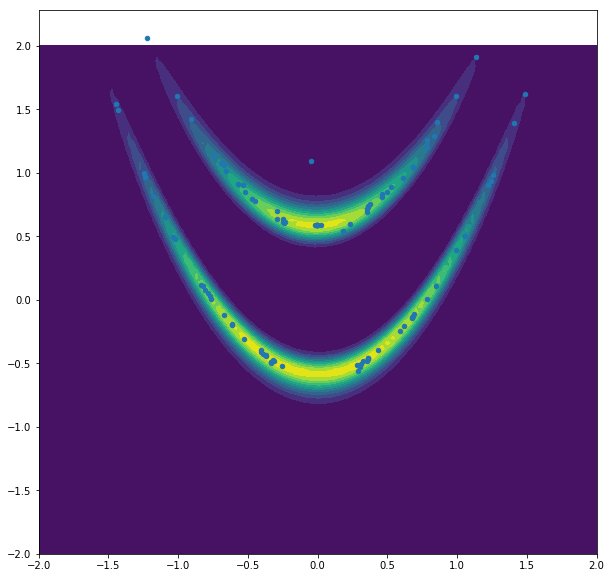

In [298]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-2, 2, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) ) \
                .reshape(ngrid, ngrid)
plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(ssvgd.particles[0], ssvgd.particles[1], s = 20)

# Intrusive Sequential SVN

In [431]:
class SeqSVN:
    def __init__(self, model, *arg):
        self.model = model
        self.DoF = model.DoF
        self.nParticles = 1
        self.nIterations = 100
        self.stepsize = 1
        self.MAP = self.model.getMAP( np.random.normal( size = self.DoF ) )[:,np.newaxis]
        self.particles = self.MAP
        self.gmlpts = self.model.getGradientMinusLogPosterior(self.MAP).reshape(self.DoF, 1)
        self.Hmlpts = self.model.getGNHessianMinusLogPosterior(self.MAP).reshape(self.DoF,self.DoF,1)
        self.M      = self.Hmlpts.squeeze()
        
    def apply(self):
        maxshiftold = np.inf
        particle = self.generateParticle()
        
        for iter_ in range(self.nIterations):
            F = self.model.getForwardModel(particle)
            J = self.model.getJacobianForwardModel(particle)
            gmlpt  = self.model.getGradientMinusLogPosterior(particle, F, J).reshape(self.DoF, 1)
            Hmlpt  = self.model.getGNHessianMinusLogPosterior(particle, J).reshape(self.DoF, self.DoF, 1)
            
            gmlpts = np.append( self.gmlpts, gmlpt, 1 )
            Hmlpts = np.append( self.Hmlpts, Hmlpt, 2 )
            M = (self.nParticles * self.M + Hmlpt.squeeze()) / (self.nParticles + 1)
            particles = np.append( self.particles, particle, 1) 
            
            sign_diff = particle - particles
            Msd   = np.matmul(M, sign_diff)
            kern  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
            gkern = Msd * kern

            mgJ = np.mean(- gmlpts * kern + gkern , 1)
            HJ  = np.mean(Hmlpts * kern ** 2, 2) + np.matmul(gkern, gkern.T) / (self.nParticles + 1)
            Q = np.linalg.solve(HJ, mgJ)
            particle += self.stepsize * Q[:,np.newaxis]

            maxshift = np.linalg.norm(Q, np.inf)
            if maxshift < maxshiftold:
                self.stepsize *= 1.01
            else:
                self.stepsize *= 0.9
            maxshiftold = maxshift
            
        self.gmlpts = np.append( self.gmlpts, gmlpt, 1 )
        self.Hmlpts = np.append( self.Hmlpts, Hmlpt, 2 )
        self.M = (self.nParticles * self.M + Hmlpt) / (self.nParticles + 1)
        self.particles = np.append( self.particles, particle, 1) 
        self.nParticles += 1
            
    def generateParticle(self):
        return np.random.normal( scale = 1, size = (self.DoF, 1) )


In [432]:
model = GAUSSIAN()

In [433]:
ssvn = SeqSVN(model)

In [434]:
for i in range(100):
    ssvn.apply()

ValueError: shapes (2,2,3) and (3,2,2) not aligned: 3 (dim 2) != 2 (dim 1)

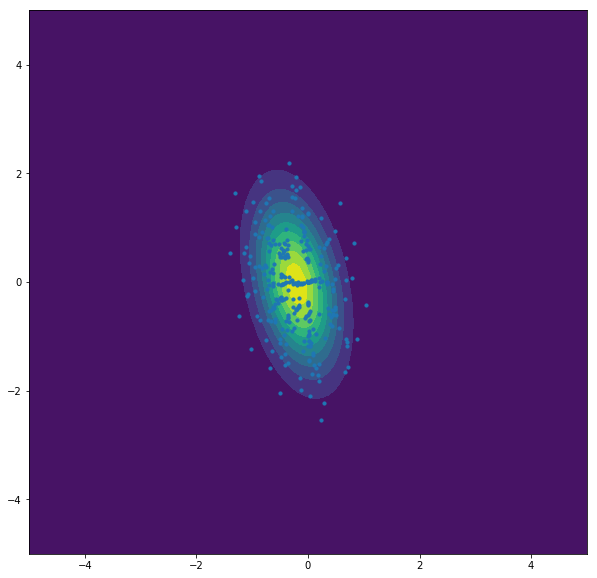

In [430]:
ngrid = 100
x = np.linspace(-5, 5, ngrid)
y = np.linspace(-5, 5, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) ) \
                .reshape(ngrid, ngrid)
plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(ssvgd.particles[0], ssvgd.particles[1], s = 10)